# Shockee

### Data Logger for Shock Absorber Dyno
by Hoey Racing Suspension with Unitek Racing

Author: Tony Rawlins
Contact 0401424024 with queries

## Arduino Code

The following is the v1 Arduino code for the data logging functions. Use Arduino IDE 2 and a USB cable to upload this code should it require any changes.

## Python code

This can be executed here inline in this Notebook or wrapped into an application

In [4]:
import time
import numpy as np
import pandas as pd
import datetime
import math

class ArduinoDataLogger:
    
    def __init__(self):
        
        self.cols = columns=['timestamp', 'a0', 's (mm)', 'n (N)', 'a (d)', 'a (r)']
        self.connection = None
        self.df = pd.DataFrame([], columns=self.cols)
        self.full_circle = {key: 'n' for key in range(360)}
    
    def connect(self):
        self.connection = serial.Serial('/dev/ttyACM1', baudrate=250000, timeout=1)  # Adjust the port and baud rate as needed
        
    def close(self):
        self.connection.close()

    def read_datalines(self, decoded):
        while not decoded:
            if not self.connection:
                self.connect()
            try:
                # This will read a full line until a newline character (\n)
                line = self.connection.readline()
                
                # Decode the line to a string and strip any trailing whitespace
                decoded_line = line.decode('utf-8').strip()
                # print(f"Response: {decoded_line}")
                
                if len(decoded_line) > 0:
                    
                    if decoded_line != "READY":
                        #print("Decoding response...")
                        # Decode the line to a string and strip any trailing whitespace
                        decoded = eval(decoded_line)
            except SyntaxError:
                pass
                    
        self.full_circle[decoded['a (d)']] = 'y'                
        return [datetime.datetime.now(),
                    decoded['a0'],
                    # decoded['a1'],
                    # decoded['a2'],
                    # decoded['a3'],
                    # decoded['a4'],
                    # decoded['a5'],
                    decoded['s (mm)'],
                    decoded['n (N)'],
                    decoded['a (d)'],
                    decoded['a (r)']]
                                
        
    def poll(self):
        rows = []
        decoded = None
        
        try:
            while 'n' in list(self.full_circle.values()):
                
                # Get the array
                row = self.read_datalines(decoded)
                rows.append(row)
                #print(self.full_circle)
                
            
                
        except KeyboardInterrupt:
            print("Exiting...")
        finally:
            if(self.connection):
                self.connection.close()
            print("Connection: closed.")
        
        self.df = pd.DataFrame(rows, columns=self.cols)
        return self.df

adl = ArduinoDataLogger()

## Capturing Data from the Dyno

We've initialised our ArduinoDataLogger as `adl`
We can now ask it to poll the machine for data. It will continue to capture data over time until every 1&deg; slice has been measured. The machine is queried approx every 1/10,000 of a second. So multiple entries per degree are quite possible. We aggregate these readings to produce an average reading for each 1&deg; slice for both compression and stroke length. As such, some smoothing may occur.

In [546]:
df = adl.poll()

Connection: closed.


## Saving our results

We can export the data for analysis in other progams in a number of formats.

Excel is the default but JSON is also an option.

In [38]:
xl = pd.DataFrame(df).T

### Saved file location

Feel free to change the path and filename of the saved file here. `Files will be overwritten` if they already exist `without warning` so be careful!

In [43]:
xl.to_excel('output.xlsx', index=True)

# Data Analysis Section

### **Recommendation**
- For general time-based analysis: **Multi-line Plot** or **Dual-axis Plot**.
- For identifying relationships: **Heatmap** or **3D Plot**.



### **1. Multi-line Time Series Plot**
A **multi-line plot** on a shared x-axis (time) works well if you want to analyze trends or relationships over time.

- **X-axis**: Time (index)
- **Y-axis**: Separate y-axis for each variable (or normalized/shared scale if comparable)
- **Lines**: One line for each variable (stroke length, compression force, and angle)

This provides an overview of how the variables change with time and if they correlate.

#### Example:

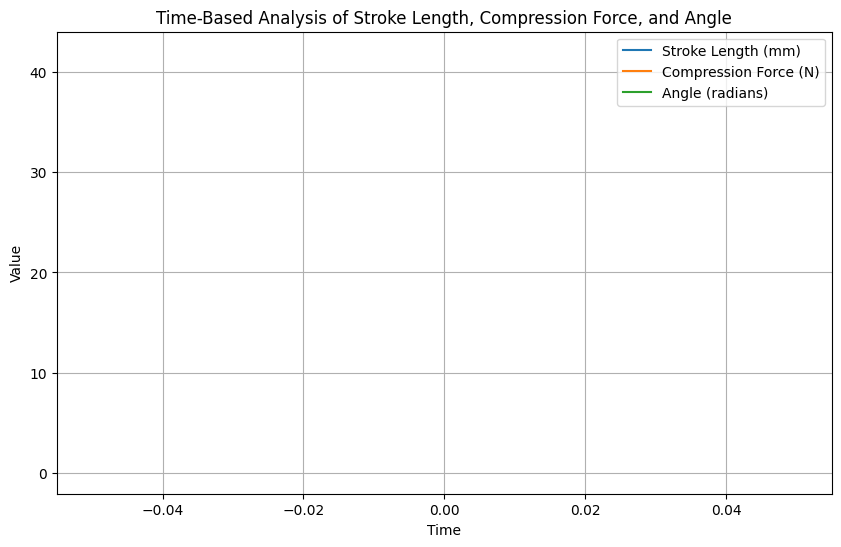

In [556]:
import matplotlib.pyplot as plt

# Assuming `df` is a DataFrame with columns 'time', 'stroke_length', 'compression_force', 'angle'
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['s (mm)'], label='Stroke Length (mm)')
plt.plot(df.index, df['n (N)'], label='Compression Force (N)')
plt.plot(df.index, df['a (r)'], label='Angle (radians)')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time-Based Analysis of Stroke Length, Compression Force, and Angle')
plt.legend()
plt.grid()
plt.show()

### **2. Dual-axis Plot**
Use dual y-axes to compare two variables directly against each other. For instance:
- Plot **stroke length** and **compression force** on the primary y-axis.
- Plot **angle** on the secondary y-axis.

This is helpful if some variables have significantly different scales (e.g., mm vs. Newtons vs. radians).

#### Example:

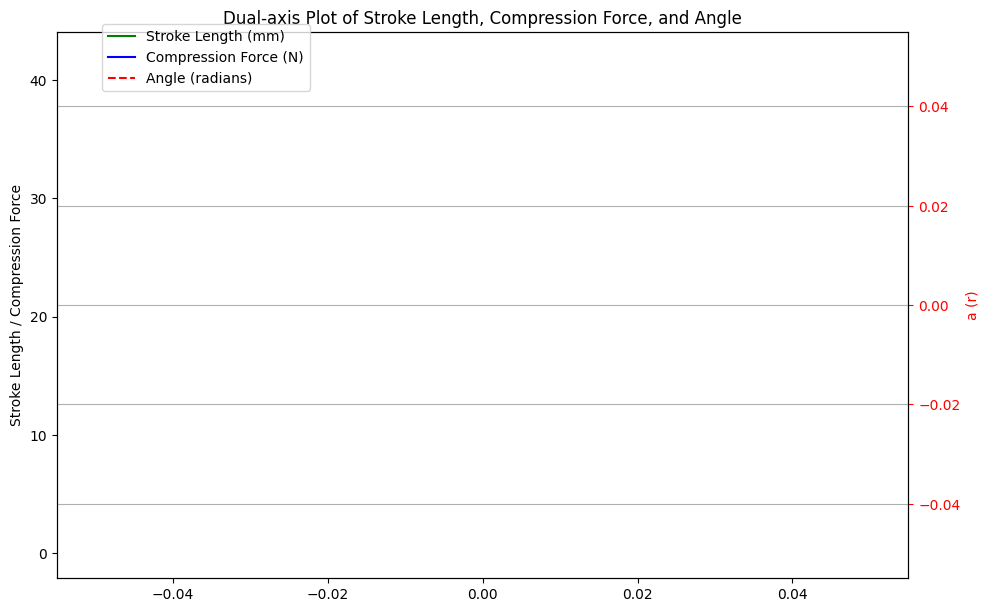

In [557]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis
ax1.plot(df.index, df['s (mm)'], 'g-', label='Stroke Length (mm)')
ax1.plot(df.index, df['n (N)'], 'b-', label='Compression Force (N)')
ax1.set_ylabel('Stroke Length / Compression Force', color='black')
ax1.tick_params(axis='y')

# Secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['a (r)'], 'r--', label='Angle (radians)')
ax2.set_ylabel('a (r)', color='red')
ax2.tick_params(axis='y', colors='red')

# Legend and Title
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.title('Dual-axis Plot of Stroke Length, Compression Force, and Angle')
plt.grid()
plt.show()

### **3. Heatmap for Correlation Analysis**
If you want to explore relationships between variables (e.g., does compression force increase with stroke length?), a heatmap is a great option.

- Use a **time window** (e.g., rolling averages) to compute correlations.
- Plot a **heatmap** of pairwise correlations.

#### Example:

/home/tony/Documents/Shockee Notebooks/notebooks/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/tony/Documents/Shockee Notebooks/notebooks/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


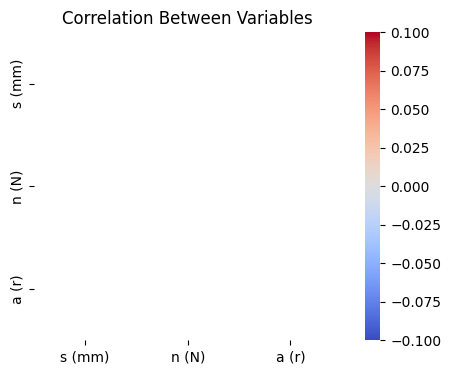

In [558]:
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df[['s (mm)', 'n (N)', 'a (r)']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Between Variables')
plt.show()

### **4. 3D Line Plot (Optional)**
If you want to visualize the relationship between all three variables over time, a **3D line plot** can help.

#### Example:

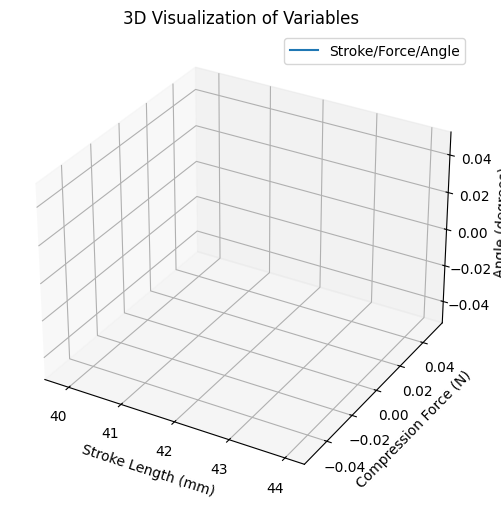

In [561]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['s (mm)'], df['n (N)'], df['a (d)'], label='Stroke/Force/Angle')

ax.set_xlabel('Stroke Length (mm)')
ax.set_ylabel('Compression Force (N)')
ax.set_zlabel('Angle (degrees)')
ax.set_title('3D Visualization of Variables')

plt.legend()
plt.show()

A **polar plot aggregated over time** is an excellent choice if you want to analyze the relationship between **angle (radians)** and the other variables (**stroke length** and **compression force**) over a full rotation or cyclical pattern.

---

### **Concept**
- We use the **angle (radians)** as the angular coordinate (θ) in the polar plot.
- Aggregate or average **stroke length** and **compression force** over time for each angle value.
- Plot the aggregated values (e.g., mean, max) as the radial coordinate (r) for each variable.

---

### **Implementation**

#### 1. **Preprocessing the Data**
You need to group your data by angle (e.g., round angle to a specific bin or degree) and aggregate the other variables.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame: df with 'time', 'stroke_length', 'compression_force', 'angle'

# Aggregate data by angle (binning for smoother visualization)
angle_bins = np.linspace(0, 2 * np.pi, 360)  # Binning into 360 points (1° each)
df['angle_bin'] = pd.cut(df['a (r)'], bins=angle_bins, labels=angle_bins[:-1])

aggregated_data = df.groupby('angle_bin')[['stroke_length', 'compression_force']].mean()
aggregated_data.index = aggregated_data.index.astype(float)  # Convert angle bins back to float

NameError: name 'df' is not defined

#### 2. **Polar Plot**
You can now create a polar plot using the aggregated data.

In [ ]:
# Polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

# Stroke Length
ax.plot(aggregated_data.index, aggregated_data['s (mm)'], label='Stroke Length (mm)', color='blue')

# Compression Force
ax.plot(aggregated_data.index, aggregated_data['n (N)'], label='Compression Force (N)', color='green')

# Formatting the plot
ax.set_theta_direction(-1)  # Clockwise rotation
ax.set_theta_offset(np.pi / 2)  # Set 0° at the top
ax.set_title('Polar Plot of Stroke Length and Compression Force', va='bottom')
ax.legend(loc='upper right')
ax.grid(True)

plt.show()

### **Details**
1. **`ax.set_theta_direction(-1)`**:
   - Ensures the plot follows the natural direction of a rotation.
2. **`ax.set_theta_offset(np.pi / 2)`**:
   - Sets 0° (angle = 0) at the top of the plot.
3. **Multiple Lines**:
   - You can add multiple lines for each variable (e.g., stroke length and compression force).

### **Optional: Using Filled Areas**
If you want a **filled polar plot** to emphasize the difference between the variables:

NameError: name 'aggregated_data' is not defined

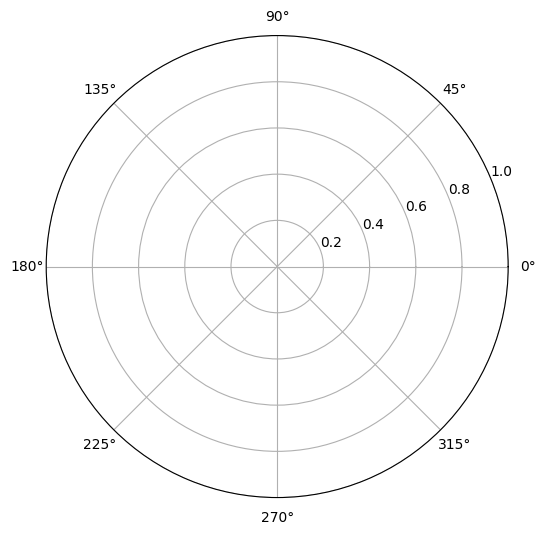

In [560]:
# Filled polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

ax.fill(aggregated_data.index, aggregated_data['s (mm)'], alpha=0.4, label='Stroke Length (mm)', color='blue')
ax.fill(aggregated_data.index, aggregated_data['n (N)'], alpha=0.4, label='Compression Force (N)', color='green')

ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)
ax.set_title('Filled Polar Plot of Stroke Length and Compression Force', va='bottom')
ax.legend(loc='upper right')
ax.grid(True)

plt.show()


### **Use Case**
A polar plot is most useful if:
- Your data has a strong periodic or cyclical nature.
- You want to see how stroke length and compression force vary as a function of the crankshaft angle.

---
# Voltage Concerns
---

To reduce a 12V signal to a level suitable for the 5V analog input pins of your Arduino, you can use a **voltage divider** circuit. A voltage divider consists of two resistors in series that scale down the voltage.

### Voltage Divider Formula:
The output voltage ($V_{out}$) is given by:

$$
V_{out} = V_{in} \cdot \frac{R_2}{R_1 + R_2}
$$

Where:
- $V_{in}$: Input voltage (12V in this case)
- $V_{out}$: Desired output voltage (5V in this case)
- $R_1$: Resistor connected between $V_{in}$ and the output
- $R_2$: Resistor connected between the output and ground

### Step 1: Solving for Resistor Ratio
We need $V_{out} = 5V$ when $V_{in} = 12V$. Plugging into the formula:

$$
5 = 12 \cdot \frac{R_2}{R_1 + R_2}
$$

Simplify:
$$
\frac{R_2}{R_1 + R_2} = \frac{5}{12}
$$

Rearranging:
$$
R_1 = R_2 \cdot \left(\frac{12}{5} - 1\right) = R_2 \cdot \frac{7}{5}
$$

So the ratio $R_1 : R_2$ should be $7 : 5$.

### Step 2: Choosing Practical Resistor Values
Select resistors with standard values that maintain the $7 : 5$ ratio. A good choice would be:
- $R_1 = 7k\Omega$
- $R_2 = 5k\Omega$

Alternatively:
- $R_1 = 14k\Omega$
- $R_2 = 10k\Omega$

### Step 3: Check the Voltage Divider Output
For $R_1 = 14k\Omega$ and $R_2 = 10k\Omega$:

$$
V_{out} = 12 \cdot \frac{10}{14 + 10} = 12 \cdot \frac{10}{24} = 5V
$$

This confirms the output is correct.

### Step 4: Consider Power Dissipation
The resistors should have a high enough resistance to limit current draw but low enough to avoid noise issues. Common values like $10k\Omega$ and $14k\Omega$ are fine, but avoid going below $1k\Omega$ unless necessary.

### Wiring the Circuit
1. Connect $V_{in}$ (12V) to one end of $R_1$.
2. Connect the other end of $R_1$ to one end of $R_2$ and the Arduino analog pin.
3. Connect the other end of $R_2$ to GND.
